In [1]:
import numpy as np
import torch
from torch.utils import data
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from matplotlib import image
from matplotlib import patches
import matplotlib.colors as mcolors
import zipfile
from pycocotools.coco import COCO
import pandas as pd
import cv2
import random as rn
%matplotlib inline

In [2]:
# Import data frames
train_df = pd.read_pickle('data-2/train_df.pkl')
val_df = pd.read_pickle('data-2/val_df.pkl')

In [3]:
kp_names = [ "nose", "left_eye", "right_eye", "left_ear", "right_ear", "left_shoulder", "right_shoulder", "left_elbow", 
    "right_elbow", "left_wrist", "right_wrist", "left_hip", "right_hip", "left_knee", "right_knee", "left_ankle", "right_ankle" ]

kp_dict = {name:i*2 for i, name in enumerate(kp_names)}
print(kp_dict)

# Takes in a CXHXW image with keypoints and displays it with keypoints
def displayImageWithKeyPoints(img, keypoints, ax=None, show=True):
    img = np.swapaxes(img,0,2)
    img = np.swapaxes(img,0,1)

    #fig = None
    if(ax is None):
        fig, ax = plt.subplots()
    ax.imshow(img)
    w = img.shape[1]
    h = img.shape[0]
    
    # Show kps
    
    for i in range(1, len(keypoints), 2):
        if(i > 1 and i < 10): 
            continue
        x = keypoints[i-1]
        y = keypoints[i]
        x = (x)*w + w/2
        y = (y)*h + h/2
        if x < 0 or y < 0: continue
        colors = ['red', 'blue', 'magenta', 'lime', 'orange', 'purple', 'pink', 'yellow', 'aqua', 'fuchsia', 'azure', 'lavender', 'magenta', 'white', 'sienna', 'indigo', 'coral']
        #ax.plot(x, y, marker='x', color=colors[i//2])
        ax.plot(x, y, marker='o', color='black')

    # draw skeleton
    left_arm = ["left_shoulder", "left_elbow", "left_wrist"]
    right_arm = ["right_shoulder", "right_elbow", "right_wrist"]
    left_leg = ["left_hip", "left_knee", "left_ankle"]
    right_leg = ["right_hip", "right_knee", "right_ankle"]

    bones = [left_arm, right_arm, left_leg, right_leg]
    colors = ['red', 'blue', 'green', 'yellow']

    for i, bone in enumerate(bones):
        x_l = []
        y_l = []
        for keypoint in bone:
            idx = kp_dict[keypoint]
            x = keypoints[idx]*w + w/2
            y = keypoints[idx+1]*h + h/2
            if x < 0 or y < 0: continue
            x_l.append(x)
            y_l.append(y)
        
        ax.plot(x_l, y_l, color=colors[i], linewidth=2)
        print(x_l)
        print(y_l)
    
    # torso:
    torso_upper_x = (keypoints[kp_dict["left_shoulder"]] + keypoints[kp_dict["right_shoulder"]])/2 * w + w/2
    torso_upper_y = (keypoints[kp_dict["left_shoulder"]+1] + keypoints[kp_dict["right_shoulder"]+1])/2 * h + h/2
    torso_lower_x = (keypoints[kp_dict["left_hip"]] + keypoints[kp_dict["right_hip"]])/2 * w + w/2
    torso_lower_y = (keypoints[kp_dict["left_hip"]+1] + keypoints[kp_dict["right_hip"]+1])/2 * h + h/2
    torso_x = [torso_upper_x, torso_lower_x]
    torso_y = [torso_upper_y, torso_lower_y]
    ax.plot(torso_x, torso_y, color='magenta', linewidth=2)

    # connectors 
    face_c_x = [torso_upper_x, keypoints[kp_dict["nose"]]*w + w/2]
    face_c_y = [torso_upper_y, keypoints[kp_dict["nose"]+1]*h + h/2]
    ax.plot(face_c_x, face_c_y, color='white', linewidth=2)

    upleft_c_x = [torso_upper_x, keypoints[kp_dict["left_shoulder"]]*w + w/2]
    upleft_c_y = [torso_upper_y, keypoints[kp_dict["left_shoulder"]+1]*h + h/2]
    ax.plot(upleft_c_x, upleft_c_y, color='white', linewidth=2)

    upleft_c_x = [torso_upper_x, keypoints[kp_dict["right_shoulder"]]*w + w/2]
    upleft_c_y = [torso_upper_y, keypoints[kp_dict["right_shoulder"]+1]*h + h/2]
    ax.plot(upleft_c_x, upleft_c_y, color='white', linewidth=2)

    upleft_c_x = [torso_lower_x, keypoints[kp_dict["left_hip"]]*w + w/2]
    upleft_c_y = [torso_lower_y, keypoints[kp_dict["left_hip"]+1]*h + h/2]
    ax.plot(upleft_c_x, upleft_c_y, color='white', linewidth=2)

    upleft_c_x = [torso_lower_x, keypoints[kp_dict["right_hip"]]*w + w/2]
    upleft_c_y = [torso_lower_y, keypoints[kp_dict["right_hip"]+1]*h + h/2]
    ax.plot(upleft_c_x, upleft_c_y, color='white', linewidth=2)

    if(show):
        plt.show()
    #return np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')

{'nose': 0, 'left_eye': 2, 'right_eye': 4, 'left_ear': 6, 'right_ear': 8, 'left_shoulder': 10, 'right_shoulder': 12, 'left_elbow': 14, 'right_elbow': 16, 'left_wrist': 18, 'right_wrist': 20, 'left_hip': 22, 'right_hip': 24, 'left_knee': 26, 'right_knee': 28, 'left_ankle': 30, 'right_ankle': 32}


In [4]:
# normalizing transform defined in the DeepPose paper
# y is a 2 vec, b is a 4 vec of bcx, bcy, bw, bh
def N(y, b):
    return [ (y[0]-b[0]) * 1/b[2], (y[1]-b[1]) * 1/b[3]]

def Ninv(y, b):
    return []

In [5]:
# Create datasets for training and validation
class Coco(Dataset):
    def __init__(self, df, source, dimensions, transform=None):
        super().__init__()
        # Dataframe of annotations
        self.df = df
        # Either train or val to indicate set
        self.source = source
        # Square dimensions of image
        self.dimensions = dimensions
        # transform
        self.transform = transform

    def __getitem__(self, index):
        # Get data
        img = image.imread(f'data-2/{self.source}2017/{self.df.iloc[index]["path"]}')
        
        # Apply transforms to image
        if self.transform: img = self.transform(img)

        label = torch.FloatTensor(self.df.iloc[index]["keypoints"])

        # random augmentation
        
        
        # Return data
        return img, label

    def __len__(self):
        return len(self.df)

[tensor(129.4426), tensor(153.3115), tensor(197.3770)]
[tensor(22.4000), tensor(12.5176), tensor(5.9294)]
[tensor(64.2623), tensor(27.5410), tensor(16.5246)]
[tensor(38.8706), tensor(58.6353), tensor(86.9647)]
[tensor(120.2623), tensor(134.9508), tensor(134.0328)]
[tensor(81.6941), tensor(138.3529), tensor(193.0353)]
[tensor(83.5410), tensor(58.7541), tensor(55.0820)]
[tensor(79.0588), tensor(88.9412), tensor(142.9647)]


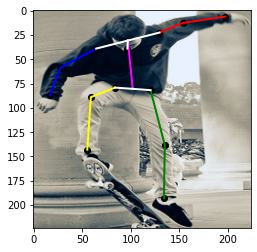

In [6]:
# Data loader
composed_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
train_dataloader = DataLoader(
    dataset=Coco(train_df, 'train', 224, transform=composed_transforms),
    batch_size=1, shuffle=True, num_workers=0
)

# Example from data loader after normalization
img, labels = iter(train_dataloader).next()
#print(labels)
a = img[0].numpy()
b = (a - np.min(a))/np.ptp(a)
displayImageWithKeyPoints(b, labels[0])

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("No GPU")

Using the GPU!


In [18]:
# Initialize network
'''
model = models.resnet18(pretrained=True)#models.mobilenet_v2(pretrained=True)

# Freeze params
'''
#for param in model.parameters():
#    param.requires_grad = False
'''

# Replace FC
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=False), 
    torch.nn.Linear(512, 4096),
    nn.ReLU(),
    torch.nn.Dropout(p=0.5, inplace=False),
    torch.nn.Linear(4096, 4096),
    nn.ReLU(),
    torch.nn.Dropout(p=0.5, inplace=False),
    torch.nn.Linear(4096, 34),
    torch.nn.Sigmoid()
    ) 
model = model.to(device)
model
'''

model = torch.nn.Sequential(
    torch.nn.Conv2d(3, 96, kernel_size=(11, 11), stride=(4,4), padding=(5,5)),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(96),

    torch.nn.MaxPool2d(kernel_size=(2, 2)),

    torch.nn.Conv2d(96, 256, kernel_size=(5, 5), padding=(2,2)),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(256),

    torch.nn.MaxPool2d(kernel_size=(2, 2)),

    torch.nn.Conv2d(256, 384, kernel_size=(3, 3), padding=(1,1)),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(384),

    torch.nn.Conv2d(384, 384, kernel_size=(3, 3), padding=(1,1)),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(384),

    torch.nn.Conv2d(384, 256, kernel_size=(3, 3), padding=(1,1)),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(256),

    torch.nn.MaxPool2d(kernel_size=(2, 2)),
    torch.nn.Flatten(),

    torch.nn.Linear(12544, 4096),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.6),

    torch.nn.Linear(4096, 4096),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.6),

    torch.nn.Linear(4096, 34),
)

model = model.to(device)
model(torch.rand(32,3,224, 224).to('cuda')).shape


torch.Size([32, 34])

In [19]:
model.load_state_dict(torch.load("models/model5700_300.save", map_location=device))

<All keys matched successfully>

In [20]:
val_dataset = Coco(val_df, 'val', 224, transform=composed_transforms)
batch_size = 32
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size, shuffle=True, num_workers=0
)
criterion = nn.MSELoss(size_average=None, reduce=None, reduction='mean')

def check_validation_accuracy(model):
    
    with torch.no_grad():
        loss = 0
        for i, data in enumerate(val_dataloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # get predictions
            outputs = model(inputs) - 0.5
            loss += criterion(outputs, labels)

        print(f"Validiation loss was {loss}")
    
    # visualize some random gt vs prediction
    '''
    idx = rn.randint(0, 150)
    img, labels = val_dataset[idx]
    a = img.numpy()
    b = (a - np.min(a))/np.ptp(a)
    
    img = img.to(device)
    outputs = model(img.unsqueeze(0))
    outputs = outputs.to('cpu') - 0.5

    fig, (ax0, ax1) = plt.subplots(1, 2)
    displayImageWithKeyPoints(b, labels, ax0, False)
    displayImageWithKeyPoints(b, outputs[0].detach().numpy(), ax1, True)
    '''
    return loss 
    

check_validation_accuracy(model)

Validiation loss was 0.03702935948967934


tensor(0.0370, device='cuda:0')

In [17]:
# TRAINING
train_dataset = Coco(train_df, 'train', 224, transform=composed_transforms)
batch_size = 64
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size, shuffle=True, num_workers=0
)

# Define loss and optimizer
criterion = nn.MSELoss(size_average=None, reduce=None, reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.000001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)#optim.SGD(model.parameters(), lr=0.0001)#optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

epochs = 3000

print(f"Training {epochs} epochs. Dataset is {len(train_dataset)} big. Using batch size {batch_size}")
print(f"{len(train_dataset)//batch_size+1} minibatches are needed per epoch")

train_loss_history = []
val_loss_history = []

# Train for 2 epochs
for epoch in range(epochs):

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs) - 0.5
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 50 == 0:
            print(f"Minibatch {i+1}/{len(train_dataset)//batch_size+1}. Loss {loss.item()}")

    # print statistics
    print(f"Epoch {epoch}/2. Loss {running_loss}")
    train_loss_history.append(running_loss)
    val_loss_history.append(check_validation_accuracy(model))
    if(epoch % 100 == 0):
        torch.save(model.state_dict(), f'models/model6000_{epoch}.save')

# save model
plt.plot(val_loss_history)
plt.figure()
plt.plot(train_loss_history)
torch.save(model.state_dict(), 'model.save')

Training 3000 epochs. Dataset is 4037 big. Using batch size 64
64 minibatches are needed per epoch
Minibatch 1/64. Loss 0.000622473715338856
Minibatch 51/64. Loss 0.0007578257354907691
Epoch 0/2. Loss 0.04265015650889836
Validiation loss was 0.03683001548051834
Minibatch 1/64. Loss 0.0005362143274396658
Minibatch 51/64. Loss 0.0009067623759619892
Epoch 1/2. Loss 0.04273055726662278
Validiation loss was 0.03657396510243416
Minibatch 1/64. Loss 0.0006067156791687012
Minibatch 51/64. Loss 0.0006945745553821325
Epoch 2/2. Loss 0.04386711894767359
Validiation loss was 0.03668190911412239
Minibatch 1/64. Loss 0.0005552956718020141
Minibatch 51/64. Loss 0.0008113303338177502
Epoch 3/2. Loss 0.0452078400994651
Validiation loss was 0.03544716164469719
Minibatch 1/64. Loss 0.0006252609309740365
Minibatch 51/64. Loss 0.0006001928122714162
Epoch 4/2. Loss 0.0432649371214211
Validiation loss was 0.03625286743044853
Minibatch 1/64. Loss 0.0005845956620760262
Minibatch 51/64. Loss 0.00063315615989267

KeyboardInterrupt: 

In [26]:
def findAvgPcp(model, dataloader):
    joint_indices = ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle']

    # Finds PCP utilizing these limbs
    # Already input limbs form: upper_leg_r and upper_leg_l from the paper
    right_l_1 = 'right_knee'
    right_l_2 = 'right_hip'
    left_l_1 = 'left_knee'
    left_l_2 = 'left_hip'
    
    average_pcps = {
        'left_limb': 0,
        'right_limb': 0,
        'total_data': 0
    }
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs) - 0.5
                
                batch_size = inputs.shape[0]

                # Find locations of all joints that are labeled in outputs and true labels
                outputs_right_l_1 = outputs[:,joint_indices.index(right_l_1):joint_indices.index(right_l_1)+2]
                outputs_right_l_2 = outputs[:,joint_indices.index(right_l_2):joint_indices.index(right_l_2)+2]
                outputs_left_l_1 = outputs[:,joint_indices.index(left_l_1):joint_indices.index(left_l_1)+2]
                outputs_left_l_2 = outputs[:,joint_indices.index(left_l_2):joint_indices.index(left_l_2)+2]

                labels_right_l_1 = labels[:,joint_indices.index(right_l_1):joint_indices.index(right_l_1)+2]
                labels_right_l_2 = labels[:,joint_indices.index(right_l_2):joint_indices.index(right_l_2)+2]
                labels_left_l_1 = labels[:,joint_indices.index(left_l_1):joint_indices.index(left_l_1)+2]
                labels_left_l_2 = labels[:,joint_indices.index(left_l_2):joint_indices.index(left_l_2)+2]
                
                # Find L2 distance from joint true to predicted location
                d_r_l_1 = torch.abs(torch.sum((labels_right_l_1 - outputs_right_l_1), 1)) **.5
                d_r_l_2 = torch.abs(torch.sum((labels_right_l_2 - outputs_right_l_2), 1)) **.5
                d_l_l_1 = torch.abs(torch.sum((labels_left_l_1 - outputs_left_l_1), 1)) **.5
                d_l_l_2 = torch.abs(torch.sum((labels_left_l_2 - outputs_left_l_2), 1)) **.5
                
                # Find L2 distance of the total limb eg: hip to knee is upper-leg
                r_limb = torch.abs(torch.sum((labels_right_l_1 - labels_right_l_2), 1)) ** .5 / 2
                l_limb = torch.abs(torch.sum((labels_left_l_1 - labels_left_l_2), 1)) ** .5 / 2
                
                # If sum of distances from true to predicted location for that limb is less than half the limb length
                # Then count instance as correctly classified in PCP
                average_pcps['right_limb'] += len(torch.where((d_r_l_1 + d_r_l_2 < r_limb))[0])
                average_pcps['left_limb'] += len(torch.where((d_l_l_1 + d_l_l_2 < l_limb))[0])
                average_pcps['total_data'] += batch_size
                
    return average_pcps

findAvgPcp(model, val_dataloader)

{'left_limb': 40, 'right_limb': 57, 'total_data': 159}

[tensor(141.9406), tensor(157.4653), tensor(174.0990)]
[tensor(50.6667), tensor(88.), tensor(144.)]
[tensor(58.7723), tensor(54.3366), tensor(73.1881)]
[tensor(54.2222), tensor(117.3333), tensor(166.2222)]
[tensor(105.3465), tensor(137.5049), tensor(177.4258)]
[tensor(81.7778), tensor(114.6667), tensor(182.2222)]
[tensor(47.6832), tensor(39.9208), tensor(26.6139)]
[tensor(80.8889), tensor(121.7778), tensor(192.8889)]
[128.17328071594238, 152.91598320007324, 160.58298110961914]
[58.16715908050537, 87.42169380187988, 97.80587673187256]
[47.64955520629883, 33.31204414367676, 70.07006168365479]
[58.91331100463867, 95.05311012268066, 102.30347633361816]
[100.201171875, 125.44548797607422, 149.08605575561523]
[107.69923400878906, 138.22871780395508, 192.21314430236816]
[46.800283432006836, 56.013404846191406, 73.44340324401855]
[110.28891944885254, 142.75900840759277, 188.31678009033203]


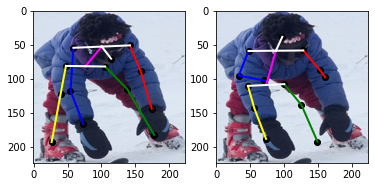

[tensor(170.3473), tensor(214.6108), tensor(198.5150)]
[tensor(38.9853), tensor(69.3805), tensor(37.6637)]
[tensor(85.8443), tensor(8.0479), tensor(56.3353)]
[tensor(38.9853), tensor(60.7906), tensor(83.2566)]
[tensor(160.9581), tensor(202.5389), tensor(191.8084)]
[tensor(107.7050), tensor(151.9764), tensor(205.4985)]
[tensor(104.6228), tensor(103.2814), tensor(101.9401)]
[tensor(111.0089), tensor(161.2271), tensor(212.1062)]
[162.51138305664062, 174.52922821044922, 158.7485466003418]
[41.200382232666016, 63.461158752441406, 74.99959373474121]
[77.86322402954102, 47.57440662384033, 57.377641677856445]
[43.122535705566406, 61.833831787109375, 59.33203887939453]
[165.61437797546387, 165.00058555603027, 156.1132526397705]
[103.49475860595703, 154.24633407592773, 192.4596652984619]
[99.08640670776367, 101.54526138305664, 93.62852478027344]
[105.27937889099121, 154.56861114501953, 192.16493225097656]


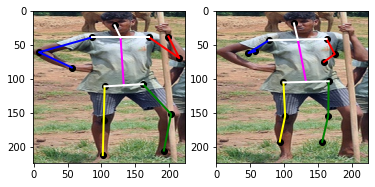

[tensor(165.0526), tensor(183.3918), tensor(208.2807)]
[tensor(48.7675), tensor(80.1771), tensor(62.8192)]
[tensor(78.5965), tensor(45.8480), tensor(37.9883)]
[tensor(46.2878), tensor(84.3100), tensor(61.1661)]
[tensor(138.8538), tensor(121.8246), tensor(103.4854)]
[tensor(114.8930), tensor(160.3542), tensor(200.0295)]
[tensor(74.6667), tensor(41.9181), tensor(26.1988)]
[tensor(112.4133), tensor(154.5683), tensor(212.4280)]
[152.02330589294434, 183.19236373901367, 197.6682891845703]
[45.2440128326416, 71.68752193450928, 69.01902294158936]
[73.65861511230469, 40.05228519439697, 45.90257930755615]
[43.95254135131836, 69.70584774017334, 66.26701736450195]
[131.0903034210205, 131.9404296875, 119.54774284362793]
[103.91964149475098, 149.8532829284668, 197.1216278076172]
[74.95479965209961, 67.24213981628418, 47.204965591430664]
[102.90185451507568, 149.16799354553223, 197.48489379882812]


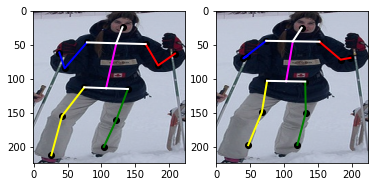

[tensor(175.), tensor(175.), tensor(105.)]
[tensor(54.9020), tensor(83.4510), tensor(76.8627)]
[tensor(77.), tensor(28.), tensor(35.)]
[tensor(48.3137), tensor(76.8627), tensor(54.9020)]
[tensor(175.), tensor(182.), tensor(196.)]
[tensor(118.5882), tensor(160.3137), tensor(186.6667)]
[tensor(91.), tensor(98.), tensor(91.)]
[tensor(118.5882), tensor(155.9216), tensor(210.8235)]
[172.08070755004883, 179.97434616088867, 125.10216903686523]
[45.55200386047363, 73.30926132202148, 65.85772895812988]
[62.0123405456543, 30.649059295654297, 49.43412208557129]
[49.11715888977051, 81.15199756622314, 81.12006092071533]
[149.5806999206543, 139.23677825927734, 168.94337272644043]
[107.92662906646729, 156.09131622314453, 190.28117752075195]
[84.32634925842285, 70.14666557312012, 86.95731735229492]
[111.81834030151367, 157.95205307006836, 205.81488418579102]


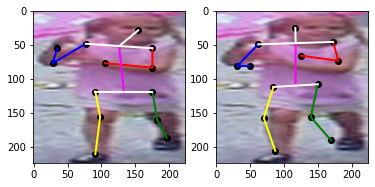

[tensor(167.3563), tensor(216.2759), tensor(177.6552)]
[tensor(61.4698), tensor(108.3535), tensor(100.0186)]
[tensor(41.1954), tensor(15.4483), tensor(74.6667)]
[tensor(62.5116), tensor(111.4791), tensor(102.1023)]
[tensor(159.6322), tensor(139.0345), tensor(164.7816)]
[tensor(137.5256), tensor(219.8326), tensor(207.3302)]
[tensor(59.2184), tensor(36.0460), tensor(92.6897)]
[tensor(135.4419), tensor(218.7907), tensor(205.2465)]
[166.21902465820312, 181.2766456604004, 173.56506729125977]
[55.33437728881836, 85.20180988311768, 93.08196353912354]
[51.24611282348633, 14.354440689086914, 59.52102184295654]
[56.45599842071533, 87.33171844482422, 89.51090049743652]
[141.8870792388916, 141.8569450378418, 130.9620361328125]
[120.82184410095215, 158.20300674438477, 194.1600513458252]
[75.21660804748535, 63.9086856842041, 63.75953006744385]
[121.42135047912598, 159.11910247802734, 204.9462661743164]


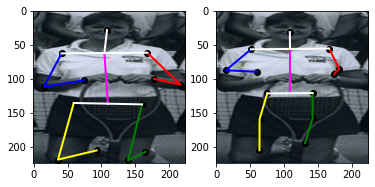

tensor([-0.0159, -0.3614,  0.0277, -0.3834, -0.0680, -0.3825,  0.0970, -0.3752,
        -0.1395, -0.3753,  0.2420, -0.2530, -0.2712, -0.2480,  0.3093, -0.1196,
        -0.4359, -0.1101,  0.2748, -0.0845, -0.2343, -0.1004,  0.1334,  0.0394,
        -0.1642,  0.0421,  0.1333,  0.2063, -0.2147,  0.2104,  0.0847,  0.3668,
        -0.2154,  0.4149], grad_fn=<SelectBackward0>)


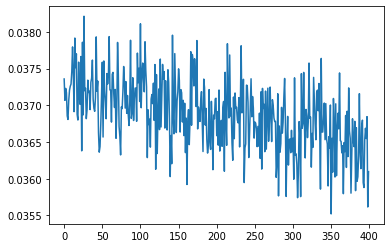

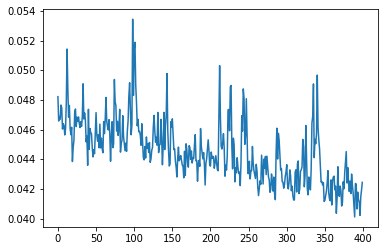

In [23]:
for q in range(0, 5):
    idx = rn.randint(0, 150)
    img, labels = val_dataset[idx]
    a = img.numpy()
    b = (a - np.min(a))/np.ptp(a)

    img = img.to(device)
    outputs = model(img.unsqueeze(0)) - 0.5
    outputs = outputs.to('cpu')

    fig, (ax0, ax1) = plt.subplots(1, 2)
    displayImageWithKeyPoints(b, labels, ax0, False)
    displayImageWithKeyPoints(b, outputs[0].detach().numpy(), ax1, True)

print(outputs[0])
plt.plot(val_loss_history)
plt.figure()
plt.plot(train_loss_history)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

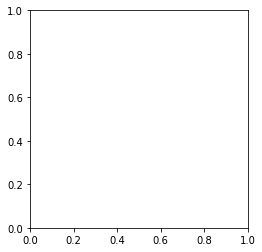

In [11]:
# real time video demo
cap = cv2.VideoCapture(0)
while(True):
    ret, frame = cap.read()
    res = cv2.resize(frame,(224, 224), interpolation = cv2.INTER_CUBIC)
    #res = np.moveaxis(res, -1, 0)
    #cv2.imshow('frame', res)

    res = np.moveaxis(res, -1, 0)
    res = res[np.newaxis]
    res = torch.Tensor(res)
    res = res.to("cuda")
    out = model(res) - 0.5
    out = out.to('cpu')
    displayImageWithKeyPoints(res, out, ax=None, show=True)


    if(cv2.waitKey(10) == ord('q')):
        break
cap.release()
cv2.destroyAllWindows()